# Make Images with Left-Right differences in every voxel  

Each voxel on the left hemisphere will carry the L-R difference between itself and it's counterpart on the other side. The right hemisphere voxels will carry the same information, but with inverted sign. Therefore, this is also a step of data reduction, eliminating 50% of information in the timeseries.

### import modules

In [1]:
import os

import pandas as pd

import nibabel as nib
from nilearn import input_data,image,plotting

### get directory

In [ ]:
# after converstion to .py, we can use __file__ to get the module folder
try:
    thisDir = os.path.realpath(__file__)
# in notebook form, we take the current working directory (we need to be in 'notebooks/' for this!)
except:
    thisDir = '.'
# convert relative path into absolute path, so this will work with notebooks and py modules
supDir = os.path.abspath(os.path.join(os.path.dirname(thisDir), '..'))

supDir

### get data

In [3]:
data_df = pd.read_csv('../data/interim/csv/info_epi_zscored_df.csv',index_col=[0],header=0)

In [ ]:
data_df.tail()

### define whole-brain masker

In [5]:
masker = input_data.NiftiMasker('%s/data/external/MNI152_T1_2mm_brain_mask.nii.gz'%supDir).fit()

In [6]:
plotting.plot_roi(masker.mask_img_);

### Flip image Left-Right

In [7]:
def make_flip(fileName):
    """get an image and flip it along the x-axis (i.e. L-R flip)"""

    # load the image file
    img = nib.load(fileName)
    # get image and header
    image_data, image_affine = img.get_data(), img.affine
    # make L-R flip
    flip_img = nib.Nifti1Image(image_data[::-1], image_affine)

    return flip_img

Example:

In [10]:
p_name = data_df.index[-1]
p_name

'pat101_a'

In [11]:
orig_im = data_df.loc[p_name,'z-scored']
flip_im = make_flip(orig_im)

In [12]:
plotting.plot_stat_map(image.index_img(orig_im,15),cut_coords=(-50,20,20),title='original');
plotting.plot_stat_map(image.index_img(flip_im,15),cut_coords=(-50,20,20),title='L/R-flipped');

### compute Left-Right difference

In [13]:
def make_diff_im(orig_im,flip_im,masker=masker):
    """compute the difference between original and flipped image, i.e. the L-R difference in each voxel"""
    
    # get original data
    this_data = masker.transform( orig_im )
    # get flipped data
    flip_data = masker.transform( flip_im )
    # difference orig - flip
    diff_data = this_data-flip_data
    # transform back into image space
    diff_im = masker.inverse_transform(diff_data)
    
    return diff_im

Example:

In [14]:
diff_im = make_diff_im(orig_im,flip_im)

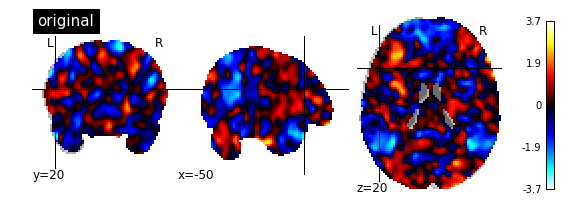

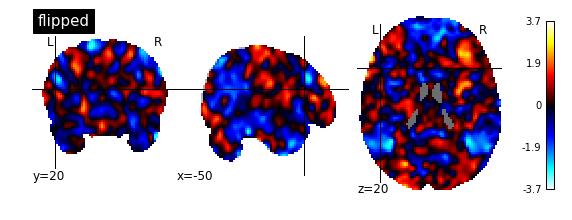

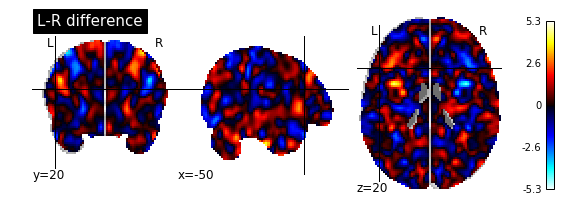

In [18]:
plotting.plot_stat_map(image.index_img(orig_im,15),cut_coords=(-50,20,20),title='original');
plotting.plot_stat_map(image.index_img(flip_im,15),cut_coords=(-50,20,20),title='flipped');
plotting.plot_stat_map(image.index_img(diff_im,15),cut_coords=(-50,20,20),title='L-R difference');

### do for one patient (toolbox only)

In [19]:
#def make_p(pFolder, pName, masker=masker):
#
#    orig_im = os.path.join(pFolder, ''.join(['z_imOrig_', pName, '.nii.gz']))
#    flip_im = make_flip(orig_im)
#    diff_im = make_diff_im(orig_im,flip_im,masker=masker)
#    
#    out_name = os.path.join(pFolder, ''.join(['z_imDiff_', pName, '.nii.gz']))
#    diff_im.to_filename(out_name)
#    
#    return out_name

### do this for all patients

In [20]:
for p_name in data_df.index:
    
    orig_im = data_df.loc[p_name,'z-scored']
    flip_im = make_flip(orig_im)
    diff_im = make_diff_im(orig_im,flip_im)
    
    out_name = '../data/interim/nii/z_imDiff_%s.nii.gz'%p_name
    diff_im.to_filename(out_name)
    
    data_df.loc[p_name,'z-scored-diff'] = out_name

### store updated dataframe

In [ ]:
data_df.tail()

In [22]:
data_df.to_csv('../data/interim/csv/info_epi_zscored_zdiff_df.csv')

### summary  

We now have a L-R difference coded in the left hemisphere of each volume (and a R-L difference in the right hemisphere of each volume).


**************

< [Previous](02-mw-make-z-maps.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](04-mw-make-design-and-summary-maps.ipynb)